## KNN con CLS estratti dal longformer finetunato con task binario + topic LDA


In [1]:
import gensim
from gensim.utils import simple_preprocess
from nltk.stem.porter import *
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

### Lettura del dataset, esso è composto da 107577 record da 770 dimensioni, 768 dimensioni (cls longformer) + colonna Text + colonna Category

In [2]:
df = pd.read_csv(os.getcwd()+"/dataset/dataset_classification.csv")
df = df[df['Text'].apply(lambda x: isinstance(x, str))]

### Suddivisione in train e test, salvaiamo le categarie in vettori seprarati dopo la split , infine togliamo le colonne Text e Category¶

In [3]:
train_knn , test_knn = train_test_split(df, test_size=0.2, random_state=42)
train_cat = train_knn["Categoria"]
test_cat = test_knn["Categoria"]
train_text = train_knn["Text"]
test_text = test_knn["Text"]
train_knn.drop('Categoria', axis=1, inplace=True)
test_knn.drop('Categoria', axis=1, inplace=True)
train_knn.drop('Text', axis=1, inplace=True)
test_knn.drop('Text', axis=1, inplace=True)

### Ogni documento (di train)  viene suddiviso in parole utilizzando il metodo split. Viene creato un dizionario, il quale mappa ogni parola univoca a un ID specifico (numerico). dictionary.filter_extremes filtra i token nel dizionario eliminando quelli che appaiono in meno di 15 documenti (no_below=15) o in più del 50% dei documenti (no_above=0.5) e mantiene solo i primi 10.000 token più frequenti (keep_n=10000) . Infine veiene creato il corpus Bag of Words (BoW) 

In [4]:
processe_docs = train_text
processed_docs = [doc.split() for doc in processe_docs ]

dictionary = gensim.corpora.Dictionary(processed_docs)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=10000)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

### Allenamento modello Latent Dirichlet Allocation (LDA)     num_topics=5 per modellare 5 topic distinti

In [5]:
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                       num_topics=12, 
                                       id2word=dictionary, 
                                       passes=32,
                                       workers=2)

### Funzioni per : estrarre da ciascuno testo la distribuzione di probabilità dei topic utilizzando LDA; normalizzare questi punteggi;  aggiungere  agli  embeddings CLS  questi punteggi normalizzati.

In [6]:
def get_document_topics(bow):
    return [prob for topic, prob in lda_model.get_document_topics(bow)]
def get_lda_topic_scores(document, dictionary, lda_model):
    bow = dictionary.doc2bow(document.split())
    topic_scores = np.zeros(lda_model.num_topics)
    for topic, score in lda_model.get_document_topics(bow):
        topic_scores[topic] = score
    return topic_scores


def normalize_scores(scores):
    score_sum = sum(scores)
    if score_sum > 0:
        return [score / score_sum for score in scores]
    else:
        return [0 for score in scores]

def augment_embeddings_with_topics(embeddings, normalized_scores):
    normalized_scores_array = np.array(normalized_scores)
    
    if embeddings.shape[0] != normalized_scores_array.shape[0]:
        raise ValueError("Il numero di embeddings non corrisponde al numero di set di punteggi dei topic.")
    
    # Concateniamo gli embeddings con i punteggi dei topic ,ogni riga sarà embeddings + 5 valori dati da lda
    augmented_embeddings = np.concatenate([embeddings, normalized_scores_array], axis=1)
    
    return augmented_embeddings


In [7]:
#non cè bisogno di queste
processe_docs = train_text
processed_docs = [doc.split() for doc in processe_docs ]

### Calcolo dei punteggi

In [8]:
all_lda_scores = []

for doc in processe_docs:
    lda_scores = get_lda_topic_scores(doc, dictionary, lda_model)
    all_lda_scores.append(lda_scores)


### Normalizzazione

In [9]:
normalized_scores = [normalize_scores(score) for score in all_lda_scores ]
embeddings_array = train_knn.to_numpy()

### aggiungiamo le distribuzioni di prob ai CLS

In [10]:
augmented_embeddings = augment_embeddings_with_topics(embeddings_array, normalized_scores)
augmented_embeddings_train_df = pd.DataFrame(augmented_embeddings)


### Stessa procedura per i dati di test

In [11]:
processe_docs = test_text
processed_docs = [doc.split() for doc in processe_docs ]


In [12]:
all_lda_scores = []

for doc in processe_docs:
    lda_scores = get_lda_topic_scores(doc, dictionary, lda_model)
    all_lda_scores.append(lda_scores)


In [13]:
normalized_scores = [normalize_scores(score) for score in all_lda_scores ]
embeddings_array = test_knn.to_numpy()

In [14]:
augmented_embeddings = augment_embeddings_with_topics(embeddings_array, normalized_scores)
augmented_embeddings_test_df = pd.DataFrame(augmented_embeddings)

augmented_embeddings_test_df

,0,1,2,3,4,5,6,7,8,9,...,770,771,772,773,774,775,776,777,778,779
0,-0.059580,0.077305,0.005906,-0.055413,0.083830,0.027534,0.011697,-0.022667,0.036090,-0.079370,...,0.000000,0.000000,0.165025,0.125858,0.000000,0.000000,0.0,0.435983,0.000000,0.000000
1,-0.047242,0.022310,-0.011587,-0.115435,0.129118,-0.103795,-0.039813,0.024394,0.070700,-0.085508,...,0.000000,0.000000,0.609666,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2,-0.037668,0.062619,-0.013432,-0.100612,0.096094,-0.089378,-0.011663,-0.013502,0.026029,-0.096889,...,0.481667,0.000000,0.000000,0.147956,0.000000,0.000000,0.0,0.000000,0.000000,0.061442
3,-0.005677,0.044885,-0.006272,-0.066819,0.092975,-0.134115,-0.038803,0.002995,0.053144,-0.098622,...,0.231562,0.000000,0.000000,0.306774,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
4,-0.038842,0.017073,-0.016025,-0.063608,0.120823,-0.127070,0.022240,0.008637,0.073754,-0.155614,...,0.753125,0.000000,0.090968,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21511,-0.024440,0.022424,-0.039263,-0.051424,0.156749,-0.074169,0.011942,-0.016926,0.055521,-0.129129,...,0.000000,0.000000,0.892256,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.107744
21512,-0.048868,0.040660,0.047860,-0.095363,0.212761,-0.065781,0.004822,0.084411,0.053559,-0.127771,...,0.000000,0.000000,0.071069,0.000000,0.288176,0.000000,0.0,0.048885,0.591869,0.000000
21513,-0.045451,0.056392,-0.023234,-0.166561,0.152043,-0.047190,-0.048956,0.092496,0.071810,-0.107650,...,0.000000,0.106914,0.000000,0.000000,0.000000,0.045459,0.0,0.558077,0.289550,0.000000
21514,-0.014269,0.019756,-0.009662,-0.031494,0.108182,-0.129723,-0.029543,0.002689,0.038014,-0.075059,...,0.000000,0.294123,0.000000,0.000000,0.000000,0.317884,0.0,0.000000,0.000000,0.000000


### Creazione KNN, impostazione del paramentro K e allenamento

In [15]:

knn_classifier = KNeighborsClassifier(n_neighbors=31)
knn_classifier.fit(augmented_embeddings_train_df, train_cat)

KNeighborsClassifier(n_neighbors=31)

### Chiamiamo la funzione predict del KNN sul test

In [16]:
predizioni = knn_classifier.predict(augmented_embeddings_test_df)

### Calcolo Metriche

In [17]:

print(accuracy_score(test_cat,predizioni))
print(precision_score(test_cat,predizioni, average='macro'))
print(recall_score(test_cat,predizioni, average='macro'))
print(f1_score(test_cat,predizioni, average='macro'))
print(confusion_matrix(test_cat,predizioni))


0.8820412716118238
0.8797418812495073
0.8201074284062395
0.8430288317349642
[[4179    6  191   75  648]
 [   2  158   23    3   97]
 [ 221   11 4309  200  250]
 [  39    0   40 5042   91]
 [ 373    9  187   72 5290]]


### Matrice di confusione 

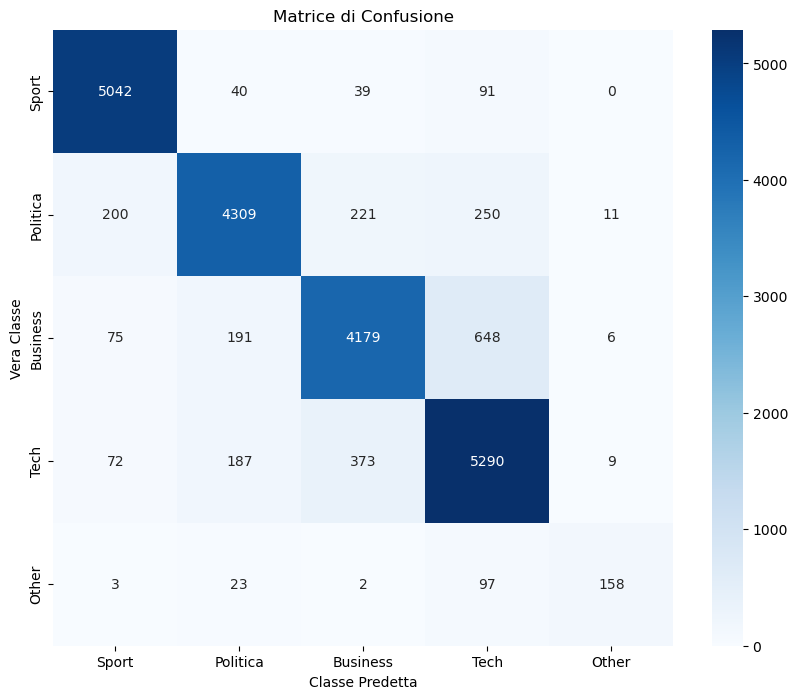

In [18]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
matrice_confusione = confusion_matrix(test_cat, predizioni, labels=['sport', 'politics', 'business', 'tech', 'other'])

# Etichette per le classi
classi = ['Sport', 'Politica', 'Business', 'Tech', 'Other']

# Creazione del grafico
plt.figure(figsize=(10, 8))
sns.heatmap(matrice_confusione, annot=True, fmt="d", cmap="Blues", xticklabels=classi, yticklabels=classi)

# Aggiunta del titolo e degli assi
plt.title('Matrice di Confusione')
plt.ylabel('Vera Classe')
plt.xlabel('Classe Predetta')

# Visualizzazione del grafico
plt.show()